In [1]:
from __future__ import division
import numpy as np
import scipy.fftpack as sf
import matplotlib.pyplot as plt
import pylab as pl
import scipy.signal as sig
from scipy import misc
from random import shuffle


## 1. STFT  (Short Time Fourier Transform) and source separation.

## In this part, we use STFT which is a collection of Fourier transform of a 1D signal on time subintervals. Why using STFT ?
- The length of a music signal for 4 minutes sampled at a rate of 44kHz is roughly $2500*44000 \simeq 1.1 \times 10^7$.
- The length of a music note is of the order of a tenth of a second.
### Conclusion: do not use FFT on the whole signal but on short segments of it.

### We use it in order to experiment source separation which comes from the idea that the different signals may present very different behaviour in the frequency domain.

In [2]:
# utils to load the sounds.
import numpy as np
import wave as wv

def load_sound(file, n0):
    
    x_raw = wv.open(file)
    n = x_raw.getnframes()
    x = np.frombuffer(x_raw.readframes(-1), 'Int16')
    x_raw.close()
    
    if file[::-1][:8][::-1] == "res/bird.wav":
        x = np.delete(x,list(range(6001)) + list(range(12500, 15001)) + list(range(22500, 24001)) + list(range(32500,34001)))

    if n0 !=0 and n0 < n:
        x = x[:n0]
    
    return x/np.max(x)

## Hereafter, we load the $3$ sounds and plot the second one.

In [3]:
n = 1024*16
s = 3 #number of signals.
x = np.zeros([n,3])
x[:,0] = load_sound("res/bird.wav",n)
x[:,1] = load_sound("res/female.wav",n)
x[:,2] = load_sound("res/male.wav",n)

## listen to a sound.
from IPython.display import Audio
Audio(x[:,1], rate = 15000)

<ipython-input-2-7cdef27fab22>:9: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  x = np.frombuffer(x_raw.readframes(-1), 'Int16')


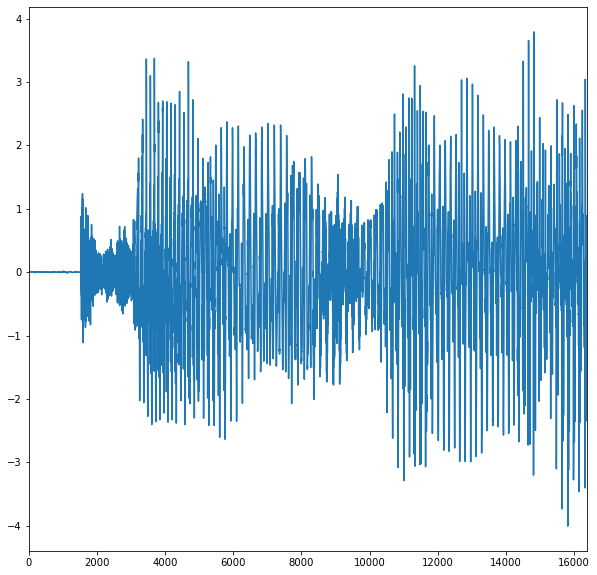

In [4]:
# Show the numerical signal.
x = x/np.tile(np.std(x,0),(n,1))
p = 2 #number of micros
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.xlim(0,n)
plt.plot(x[:,2])
plt.show()

### We simulate two micros which are implemented by linear combinations of the signals.

In [5]:
theta = np.linspace(0, np.pi, s + 1)[:-1]
theta[0] = .2
M = np.vstack((np.cos(theta), np.sin(theta)))
## recorded signals
y = np.dot(x,np.transpose(M))
print("length of the signals",np.shape(y))
# Listen to the two recorded signals.
from IPython.display import Audio
Audio(y[:,1], rate = 15000)

length of the signals (16384, 2)


### We use the STFT function from the python package signal and plot it.

16641


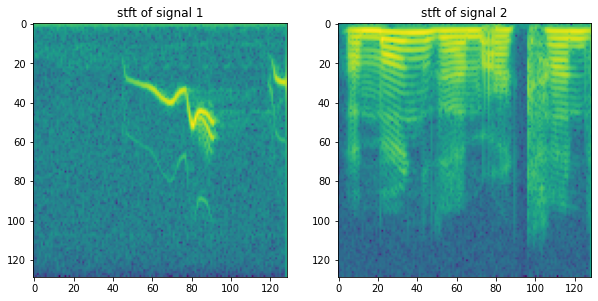

In [6]:
import scipy.signal as sig
f,t,w = sig.stft(x[:,0])
a,b,z = sig.stft(x[:,1])
print(np.size(z))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.title("stft of signal 1")
plt.imshow(np.log(np.abs(w)))
plt.subplot(1,2,2)
plt.title("stft of signal 2")
plt.imshow(np.log(np.abs(z)))

### We numerically check that the STFT and ISTFT are indeed inverse from each others.

In [7]:
micro1 = y[:,0]
micro2 = y[:,1]
stft = lambda im : sig.stft(im,noverlap = 64,nperseg = 128)
istft = lambda im : sig.istft(im,noverlap = 64,nperseg = 128)
f,t,w1 = stft(micro1)
print(np.shape(w1))
f,t,w2 = stft(micro2)
W = np.asarray([w1.flatten(),w2.flatten()])
print(np.shape(W))
t,recov = istft(w1)
print(np.sum((micro1 - recov)**2))

(65, 257)
(2, 16705)
1.1271355978742364e-27


### By selecting randomly a group of points in time, we plot in the plane the coordinates of the points, being the measured signals by the micros.

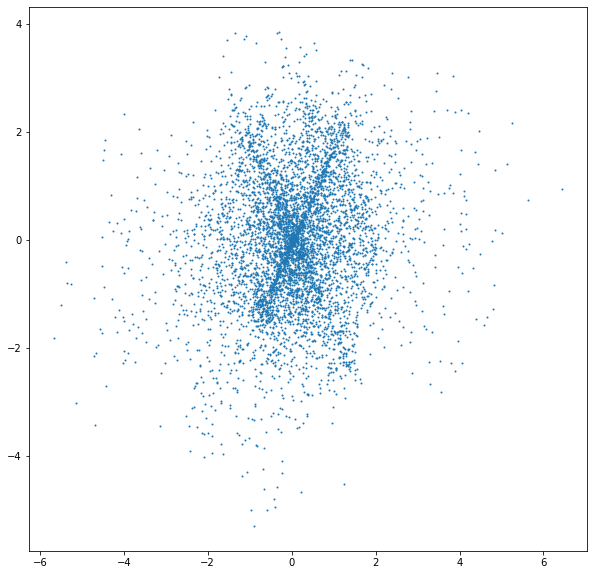

In [8]:
nbre_selec = 6000
liste = np.arange(np.shape(y)[0])
shuffle(liste)

plt.figure(figsize = (10,10))
plt.plot(y[liste[0:nbre_selec],0],y[liste[0:nbre_selec],1],"o",markersize=1)
plt.show()

## Un nuage de points sans structure.
Si l'on suppose qu'en fréquentiel toute voix est bien séparée, on obtiendra des droites.

### Q: Do the same with the STFT signals, what do you observe ?

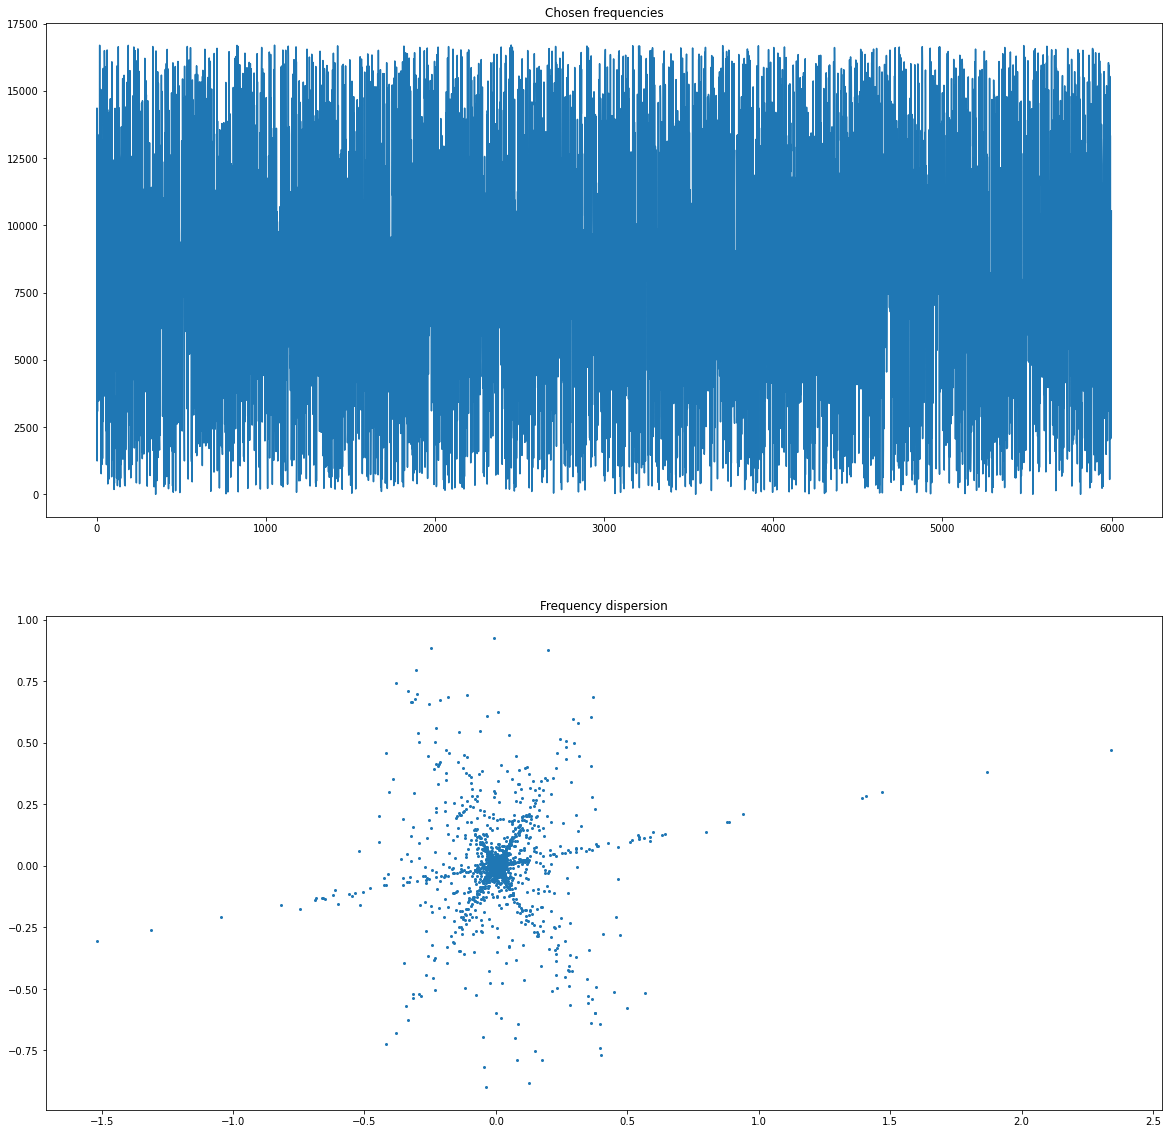

In [9]:
### your code here.
H = np.asarray([np.real(w1.flatten()),np.real(w2.flatten())]).transpose()
random_freqs = np.arange(np.shape(H)[0]) # [i for i in range(np.shape(H)[0])]
shuffle(random_freqs)

plt.figure(figsize = (20,20))
plt.subplot(2,1,1)
plt.title("Chosen frequencies")
plt.plot(np.arange(nbre_selec), random_freqs[:nbre_selec])
plt.subplot(2,1,2)
plt.title("Frequency dispersion")
plt.plot(H[random_freqs[:nbre_selec],0],H[random_freqs[:nbre_selec],1],"o",markersize=2)

plt.show()

### By selecting random frequencies, we can observe that the position of the frequencies follow a six-pointed star-shaped pattern expanding from a centre of varying position.

### We can already deduce that the six lines will be the peaks of the angle histogramme.



### Q: For each point in the plot above, compute its angle and plot the distribution of the angles (use the function np.histogram) and plot it.

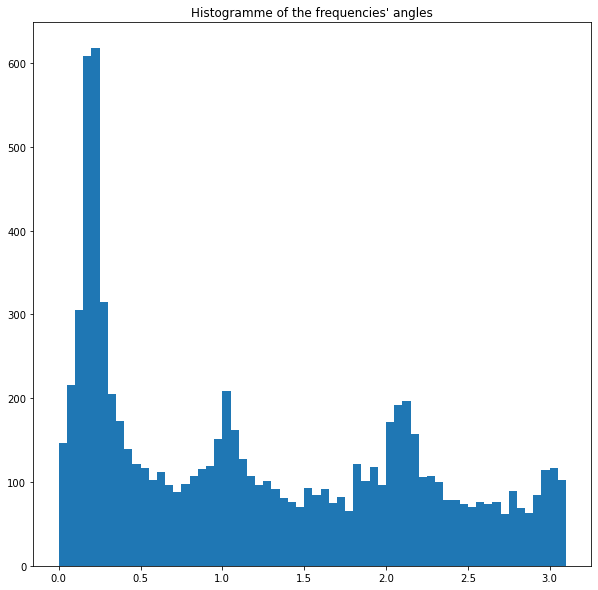

In [10]:
step = 0.05

angles = np.angle(H[:,0] + 1j*H[:,1])

# as we saw on the graph, there are six peaks.
# but the symetrical nature of it actually gives us three angles.
# In short we are not sure what the actual angles are,
# Since we are trying to triangulate a 2D position with only two values.
# We'll choose the positive angles, because we know from the above code
# that the thetas are all in [0, np.pi]
# That's cheating, but then again, who's going to stop me?
bins = np.arange(0, np.pi, step)
hist, bins = np.histogram(angles, bins)

plt.figure(figsize = (10,10))
plt.hist(angles, bins)
plt.title("Histogramme of the frequencies' angles")
plt.show()

### Q: By selecting the highest peaks of the distribution, estimate the angles of the mixing.

In [352]:
# This method is not good.
# For instance, a small variation close to a peak creates two peaks
# in the output, but it makes do with a high enough step.

# number_peaks is the number of peaks to get
# None means that we take as many as we can find.
# min_distance is the minimum distance between two peaks
# for the second not to be discarded.
# None means we get all the peaks.
def find_peaks(hist, bins, step, number_peaks=None, min_distance=None):
    # compute the derivative of the gradient
    derivative = np.gradient(hist, step)
    # the values closest to zero will mean a peak or hollow.
    # will have to check with the extremum's neighbours.
    peaks = []
    last_dist = None
    last_peak_angle = None
    # peaks will have tuples of (angle, value, variation) as elements
    for i in range(1, len(hist) - 1):
        angle = (bins[i] + bins[i+1]) / 2
        value = hist[i]
        previous_variation = derivative[i-1]
        next_variation = derivative[i]
        # if the value is higher than the lowest of the previous peaks,
        # and that the derivative is changing sign or being null
        # then we've got ourselves a peak!
        if (previous_variation*next_variation) <= 0 \
            and (min_distance is None or last_peak_angle is None or (angle - last_peak_angle) > min_distance) \
            and (number_peaks is None or len(peaks) < number_peaks or (value > peaks[-1][1])):
                peaks.append((angle, value, previous_variation, next_variation))
                 # update distance to last peak!
                last_peak_angle = angle
                # sort so that the highest peaks are first
                peaks.sort(key=lambda peak : peak[1], reverse=True)
                if number_peaks is not None:
                    # only keep the first n elements, which are n highest peaks
                    peaks = peaks[:n]
               
    # only return the angles
    peaks = np.array(peaks)
    computed_theta = np.array(peaks[:, 0])
    computed_theta.sort()
    return computed_theta

In [353]:

n = 3
# Also note that we tweaked the resolution
# So that we actually get three different peaks
# from computing the gradient, at the cost
# of reduced accuracy.


computed_theta = find_peaks(hist, bins, step, n)

err = np.linalg.norm(computed_theta - theta)

print("Computed mixing angles:")
print(computed_theta)

print("Original mixing angles:")
print(theta)

print("Error: ", err)


Computed mixing angles:
[0.225 1.075 2.125]
Original mixing angles:
[0.2        1.04719755 2.0943951 ]
Error:  0.04831807029454738


### Q: Using the STFT recorded signals, take each point in the plane and compute its projection on each recovered directions. It gives a vector of 3 estimated projections.

In [324]:
# I don't get what is implied with a 'vector of three estimated projections'.
# Okay so, from the next question I think that the result must be
# the three projections, for each point in H,
# and so in an array of three values.

# Projects a point p on line l
def compute_projection(p, l):
    n = np.linalg.norm(l)
    proj = l * (np.dot(p, l) / n**2)
    return proj

# Get the orthogonal distance of p from l
def compute_distance(p, l):
    return np.linalg.norm(compute_projection(p, l), p)

def compute_all_projections(H, directions):
    H_proj = np.empty(shape=(len(H), 3), dtype=np.complex)
    for i in range(len(H)):
        j = 0
        for d in directions:
            H_proj[i][j] = compute_projection(complex(H[i,0], H[i,1]), d)
            j += 1
    return H_proj

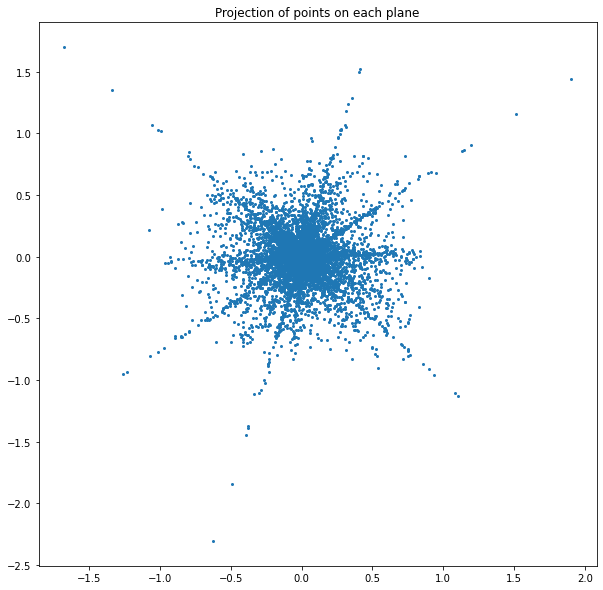

In [325]:
recovered_directions = np.exp(1j * computed_theta)

# Obviously, my projection doesn't work.
# I'll just go on to do the next thing..

H_proj = compute_all_projections(H, recovered_directions)
projected_points = H_proj.flatten().transpose()


plt.figure(figsize = (10,10))
plt.plot(np.real(projected_points), np.imag(projected_points), "o", markersize=2)
plt.title("Projection of points on each plane")
plt.show()

### Q: For each frequency point in the signal STFT, select the direction on which it has the largest projection. And threshold using the code below.

In [328]:
# I'll assume that 'largest projection' means the one
# which is closest to the actual point.

# Also, we lose the time info in W when we flattened w1 and w2,
# thus we won't be able to reconstruct the original signal from W.
# we have to use w1 and w2..

# I'll just give up on this part for now.

def compute_best_projections(w1, w2, directions, threshold):
    all_projections = compute_all_projections(H, directions)
    best_projections = np.empty_like(H)
    for in range(len(H)):
        j = 0
        dists = np.empty(shape=3)
        for d in directions:
            dists[j] = compute_distance(complex(H[i,0], H[i,1]), d)
            j += 1
        # get the closest projection. (lowest distance to point)
        j_best = np.argmax(dist)
        best_projections[i] = all_projections[i][j_best]
    # then threshold this thing...
    
        


SyntaxError: invalid syntax (<ipython-input-328-583748bab4df>, line 13)

In [ ]:
threshold = .005
D = np.sqrt(np.sum(W**2, 0))
I = I*(D > threshold)

### Q: Plot the STFT and the time domain of the recovered signals and the original signals. Estimate the performance using the SNR implemented below.

In [16]:
def snr(x, y):
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) /s)

### Q: Listen to the reconstructed signals and the original signals.

In [17]:
i = 0
from IPython.display import Audio
#Audio(X[i], rate = 15000)

In [18]:
i = 0
from IPython.display import Audio
#Audio(x[:,i], rate = 15000)

# 2. The goal of this part is to explore implementations of a FIR or an IIR.

## We plot below a signal with a mix of low and high frequencies.

(1000,) (1000,)


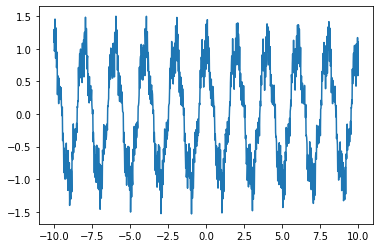

In [329]:
f = lambda t: np.cos(np.pi*t) + 0.2*np.sin(5*np.pi*t+0.1) + 0.2*np.sin(30*np.pi*t)  + 0.1*np.sin(32*np.pi*t+0.1) + 0.1*np.sin(47* np.pi*t+0.8)
t=np.linspace(-10,10,1000)
signal=f(t)
print(np.shape(t),np.shape(signal))
plt.plot(t, signal)

## Q1. Implement an ideal low pass filter using Fourier transform in 1D:
### Compute the inverse FFT of a low pass filter and cut it with a window that will be passed in argument and apply it to the signal above by convolution or using FFT.


In [330]:
def convolve_window(s, w):
    n = len(w)
    return np.real(np.fft.ifft(np.fft.fft(s, n)*w,n))

def get_lowpass_window(fc, n, sr):
    w = np.ones(n)
    freqs = np.fft.fftfreq(n, 1 / sr)
    # get the index at which we should start passing
    i = 0
    for i in range(n):
        # assumes that the freqs are ordered in this manner:
        # [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (n / sr)
        # see: https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html#numpy.fft.fftfreq
        if np.abs(freqs[i]) >= fc:
            break
        w[i]  = 0
        w[-i] = 0
    return w 

[0. 0. 0. ... 0. 0. 0.]


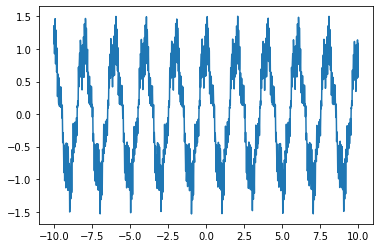

In [331]:
sr = 44100 # in Hertz
n = 2048

fc = 200


t = np.linspace(-10,10,n)
s = f(t)

lp_w = get_lowpass_window(fc, n, sr)
print(lp_w)


s_windowed = convolve_window(s, lp_w)

plt.plot(t, s_windowed)

## Q2. Using the code below, implement an IIR filter defined by its numerator which will be set to a  constant $b$ and its denominator which will be set to $1-az^{-1}$. 
### What can you say about the range of the parameter $a$ in order to obtain a stable filter. 
### Experimentally, determine the ranges of $a$ to get respectively a low-pass filter and a high-pass filter. Give a theoretical explanation.

In [332]:

def compute_iir_filter(x, h):
    ### h[0] is the numerator
    ### h[1] is the denominator
    assert(len(h[0])==len(h[0])),"the filter's two arrays must have the same length"
    y = np.zeros_like(x)
    k = len(h[0])
    for i in range(len(h[0]),len(x)):
        y[i] = np.sum(np.flipud(h[1])*y[i-k:i]) + np.sum(np.flipud(h[0]) * x[i-k+1:i+1])
    return y

def get_my_filter(a, b):
    h = np.empty(shape=(2,2))
    h[0] = [b, 0]
    h[1] = [1, -a]
    return h

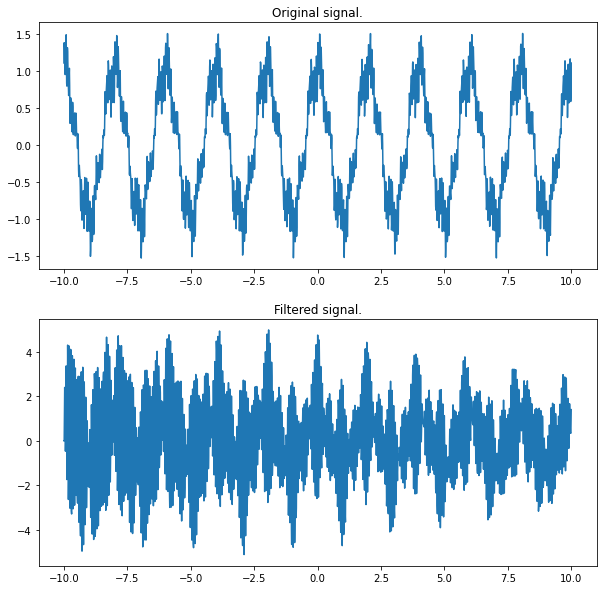

In [333]:
a = 0.999
b = 1

h = get_iir_filter(a,b)

t = np.linspace(-10,10,n)

x = f(t)

y = compute_iir(x, h)

plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.title("Original signal.")
plt.plot(t, x)
plt.subplot(2,1,2)
plt.title("Filtered signal.")
plt.plot(t, y)
plt.show()

#### We now that the ouput is defined $\iff  |z| \leq a$. We can observe this experimentally.

### consider this:
$$
    H(e^{2i \pi \nu}) = \frac{b}{1 - a e^{-2i \pi \nu}}
$$

### A low-pass filter can be obtain with $a \to 0$, as we are approaching the constant $b$.
### A high-pass filter with $a \to 1$,  when the normalised frequencies $\nu$ are close to $0$ or $1$ we get a large values in norm as $1 - z$ is close to $0$, of greater magnitude than with $\nu$ around $0.5$, for instance.

## In the following, we are given an electrocardiogram. We plot it as a function of time.

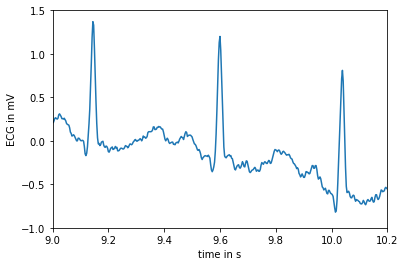

time min 0.0
time max 299.9972222222222


In [334]:
### load the data which is an electrocardiogram which is sampled at 360Hz
ecg = misc.electrocardiogram()
### Different plots.
fs = 360.0
### Since it is sampled at 360Hz, recall that Hz is the number of cycle per second, then the
### time is obtained as follows:
time = np.arange(ecg.size) / fs
### simple plot.
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(9, 10.2)
plt.ylim(-1, 1.5)
plt.show()
print("time min", time[0])
print("time max", time[-1])



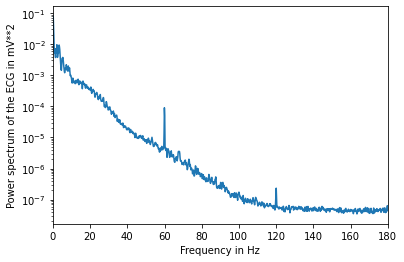

In [335]:
### Use the scipy function to get the power spectrum of the signal.
f, Pxx = sig.welch(ecg, fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

## Q3. Estimate the number of heartbeats in the following electrocardiogram and estimate the mean value of the interval between two heartbeats. You can use the method of your choice. A possible method consists in using a band pass filter and then extract the maximum values of the filtered signal.

In [336]:
def get_highpass_window(fc, n, sr):
    return np.ones(n) - get_lowpass_window(fc, n, sr)

def get_bandpass_window(f, resolution, n, sr):
    if resolution == 0:
        return np.ones(n)
    fl = f - 1 / resolution
    fh = f + 1 /resolution
    return get_lowpass_window(fl, n, sr) + get_highpass_window(fh, n, sr) - np.ones(n)


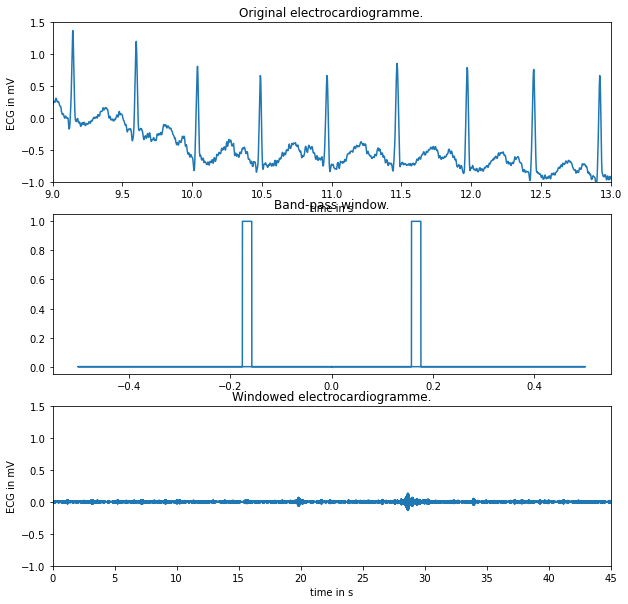

[15.00416667 15.46805556 15.94027778 16.39305556 16.84861111 17.31527778
 17.77083333 18.23194444 18.68194444 19.14305556 19.60138889 20.05694444
 20.50972222 20.96527778 21.41805556 21.87083333 22.32638889 22.77916667
 23.23194444 23.70138889 24.15694444 24.61805556]
Found 22 peaks.
Computed BPM:
131.06038717133774


In [363]:
# The graph show that the herzbeat's sound is around 60 Hertz
n = ecg.size
sr = fs # !!

f = 60# in Hertz
resolution = 0.3

w = get_bandpass_window(f, resolution, n, sr)

ecg_windowed = convolve_window(ecg, w)

### Since it is sampled at 360Hz, recall that Hz is the number of cycle per second, then the
### time is obtained as follows:
time = np.arange(ecg.size) / fs
### simple plot.
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.title("Original electrocardiogramme.")
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(9, 13)
plt.ylim(-1, 1.5)
plt.subplot(3,1,2)
plt.title("Band-pass window.")
plt.plot(np.fft.fftfreq(n), w)
plt.subplot(3,1,3)
plt.title("Windowed electrocardiogramme.")
plt.plot(time, ecg_windowed)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(0, 45)
plt.ylim(-1, 1.5)
plt.show()

# we choose a time interval
interval = time[int(15 * fs): int(25 * fs)]
ecg_interval = ecg[int(15 * fs): int(25 * fs)]
min_dist_heartbeat = 0.45 # seems reasonable, I'm absolutely not cheating.
# Basically doing the same thing as with the angles.
tmax = find_peaks(ecg_interval, interval, fs, number_peaks=None, min_distance=min_dist_heartbeat)
print(tmax)
q = len(tmax)
print("Found {0} peaks.".format(q))
# we'll just get the first and last and average on the time.
heartbeat_freq = (q - 1) / (tmax[-1] - tmax[0])

# The result is pretty skewed.
# What we'd need to get a decent approximation is 
print("Computed BPM:")
print(heartbeat_freq * 60)